<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path) # I made a mistake... sr=fs
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    # Load the spectrogram image from the disk
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
    
    # Check if tensor number i is already loaded, if not load and returns the image
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    # Try loading every images
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    # Get batch
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
            
            # Add random noise
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [14]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [16]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 128)
preloader_eval.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [34]:
# List of loss values
loss_history_train = list()
loss_history_eval = list()

# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'code_test_commented'

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-08 15:59:10
Mean Train Loss: 0.0970833430749828
Mean Evaluation Loss: 0.11910061362847972
-------------------------------------------------------------------------------------------------------
09-08 15:59:48
Mean Train Loss: 0.09638517288643891
Mean Evaluation Loss: 0.1100549893577509
-------------------------------------------------------------------------------------------------------
09-08 16:00:25
Mean Train Loss: 0.08719955143975827
Mean Evaluation Loss: 0.10271335524077807
-------------------------------------------------------------------------------------------------------
09-08 16:01:03
Mean Train Loss: 0.0831470307868689
Mean Evaluation Loss: 0.08057291694211412
-------------------------------------------------------------------------------------------------------
09-08 16:01:40
Mean Train Loss: 0.07700247670712339
Mean Evaluation Loss: 0.0753325336855091
-------------------------------------------------------------------------------------------------------


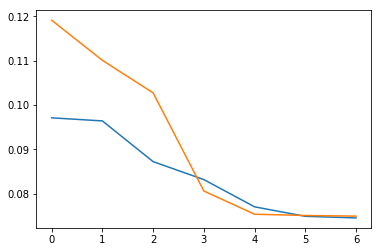

아-------------------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


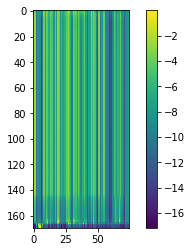

아-------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


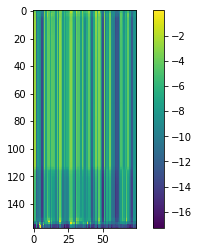

-------------------------------------------------------------------------------------------------------
09-08 16:03:33
Mean Train Loss: 0.07429845521046785
Mean Evaluation Loss: 0.07441798461428523
-------------------------------------------------------------------------------------------------------
09-08 16:04:10
Mean Train Loss: 0.07382511071623034
Mean Evaluation Loss: 0.07408195305008912
-------------------------------------------------------------------------------------------------------
09-08 16:04:48
Mean Train Loss: 0.0737238494557553
Mean Evaluation Loss: 0.07369150902120694
-------------------------------------------------------------------------------------------------------
09-08 16:05:25
Mean Train Loss: 0.07323616186701762
Mean Evaluation Loss: 0.07421992013488939
-------------------------------------------------------------------------------------------------------
09-08 16:06:02
Mean Train Loss: 0.0734470807293813
Mean Evaluation Loss: 0.07346818903976901
------------

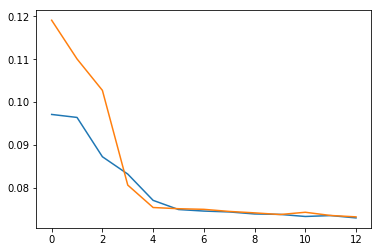

아------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


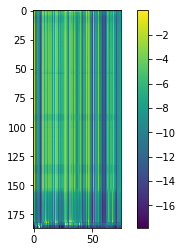

아-------------------------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos>
아다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


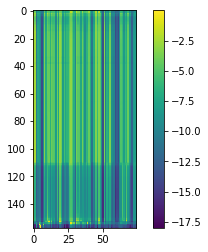

-------------------------------------------------------------------------------------------------------
09-08 16:07:18
Mean Train Loss: 0.0727823554972818
Mean Evaluation Loss: 0.07277801624977955
-------------------------------------------------------------------------------------------------------
09-08 16:07:55
Mean Train Loss: 0.07257030262107461
Mean Evaluation Loss: 0.07269102017723186
-------------------------------------------------------------------------------------------------------
09-08 16:08:33
Mean Train Loss: 0.07250780161019753
Mean Evaluation Loss: 0.07273636202708995
-------------------------------------------------------------------------------------------------------
09-08 16:09:11
Mean Train Loss: 0.07239694712344504
Mean Evaluation Loss: 0.07258600000468138
-------------------------------------------------------------------------------------------------------
09-08 16:09:48
Mean Train Loss: 0.0722113856044156
Mean Evaluation Loss: 0.07252446816369863
------------

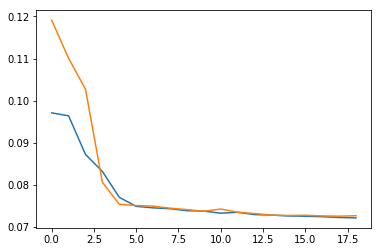

아ᄂ-----------------------------------------------------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂᆻ다.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


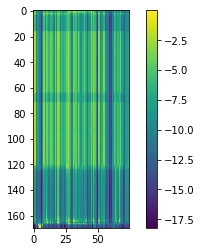

아ᄂ-----------------------------------------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂᆻ다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


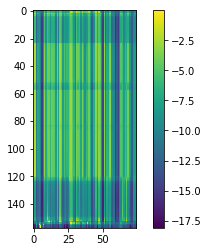

-------------------------------------------------------------------------------------------------------
09-08 16:11:04
Mean Train Loss: 0.07213538744556287
Mean Evaluation Loss: 0.0725193003509595
-------------------------------------------------------------------------------------------------------
09-08 16:11:41
Mean Train Loss: 0.07200867353720103
Mean Evaluation Loss: 0.07261606794041355
-------------------------------------------------------------------------------------------------------
09-08 16:12:18
Mean Train Loss: 0.07201646676109029
Mean Evaluation Loss: 0.07274154005059087
-------------------------------------------------------------------------------------------------------
09-08 16:12:56
Mean Train Loss: 0.07202226300724021
Mean Evaluation Loss: 0.07234882635972831
-------------------------------------------------------------------------------------------------------
09-08 16:13:33
Mean Train Loss: 0.07185665642094977
Mean Evaluation Loss: 0.07258836333352872
-----------

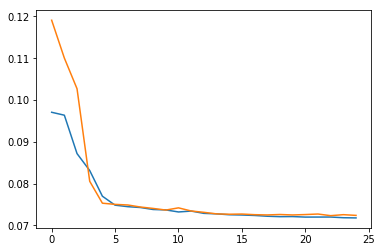

아ᄂ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂᆻ다.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


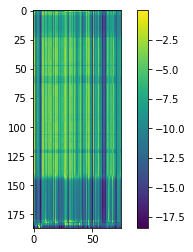

아ᄂ-----------------------------------------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂᆻ다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


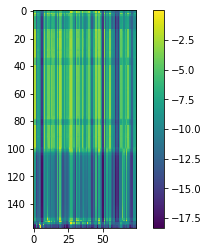

-------------------------------------------------------------------------------------------------------
09-08 16:14:49
Mean Train Loss: 0.07178350360423572
Mean Evaluation Loss: 0.07251420051055593
-------------------------------------------------------------------------------------------------------
09-08 16:15:27
Mean Train Loss: 0.07171497690557435
Mean Evaluation Loss: 0.07237826004446735
-------------------------------------------------------------------------------------------------------
09-08 16:16:04
Mean Train Loss: 0.07158870077497605
Mean Evaluation Loss: 0.07224857820705069
-------------------------------------------------------------------------------------------------------
09-08 16:16:42
Mean Train Loss: 0.07144783893166679
Mean Evaluation Loss: 0.07225425139990015
-------------------------------------------------------------------------------------------------------
09-08 16:17:19
Mean Train Loss: 0.07116740014739635
Mean Evaluation Loss: 0.07190562931619525
----------

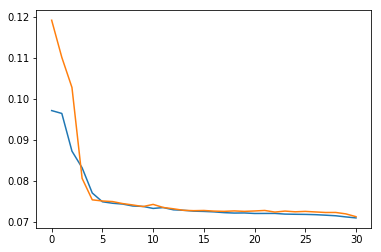

아ᄂ------------------------------------ -------------------------------- ---------------- -------------------------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂ   ᆻ다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


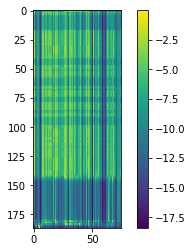

아ᄂ---------------------------------------------------------------------------  ------------------------------------------------------------------------ᆻ다.<eos><eos>
아ᄂ ᆻ다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


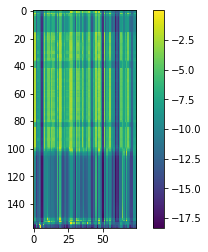

-------------------------------------------------------------------------------------------------------
09-08 16:18:35
Mean Train Loss: 0.07020301257848484
Mean Evaluation Loss: 0.06993106889771847
-------------------------------------------------------------------------------------------------------
09-08 16:19:13
Mean Train Loss: 0.0693412959696569
Mean Evaluation Loss: 0.06842611250681625
-------------------------------------------------------------------------------------------------------
09-08 16:19:51
Mean Train Loss: 0.06771064656117783
Mean Evaluation Loss: 0.06538693245371967
-------------------------------------------------------------------------------------------------------
09-08 16:20:28
Mean Train Loss: 0.0627728380182847
Mean Evaluation Loss: 0.060680843265165686
-------------------------------------------------------------------------------------------------------
09-08 16:21:05
Mean Train Loss: 0.05773991050156098
Mean Evaluation Loss: 0.05599426573204508
-----------

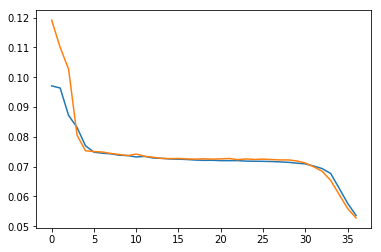

이--------------지  고르ᅵ이 서--즈-언 아-서   --------ᅮ으ᅵ은 저-자 고ᅩ-안    준가ᅡ하으  자 시ᅳᅳᆯ ᅵ  ᅡᆫ하------------------------------------------------------------------------어요.<eos><eos>
이지 고르ᅵ이 서즈언 아서 ᅮ으ᅵ은 저자 고안 준가하으 자 시ᅳᆯ ᅵ ᅡᆫ하어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


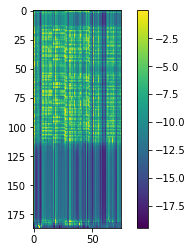

이-------------------지-나-이-ᄋ   -----자-이  ᅩᅩ옹일이  ᅡᅡᄉ사-에 이-으ᅳᆫ  -----종장안 사ᅡ을ᅡᅡ에 일오-하-아---------------------------------------ᅦ요.<eos><eos>
이지나이ᄋ 자이 ᅩ옹일이 ᅡ사에 이은 종장안 사을ᅡ에 일오하아ᅦ요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


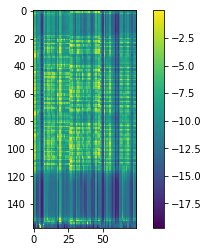

-------------------------------------------------------------------------------------------------------
09-08 16:22:22
Mean Train Loss: 0.04996047129605218
Mean Evaluation Loss: 0.050084188201381726
-------------------------------------------------------------------------------------------------------
09-08 16:22:59
Mean Train Loss: 0.046550357911965545
Mean Evaluation Loss: 0.04605584778386803
-------------------------------------------------------------------------------------------------------
09-08 16:23:36
Mean Train Loss: 0.04350150200827972
Mean Evaluation Loss: 0.04293917906575383
-------------------------------------------------------------------------------------------------------
09-08 16:24:14
Mean Train Loss: 0.04085282997514556
Mean Evaluation Loss: 0.039999902069780234
-------------------------------------------------------------------------------------------------------
09-08 16:24:51
Mean Train Loss: 0.038024316425502344
Mean Evaluation Loss: 0.03834102053879338
------

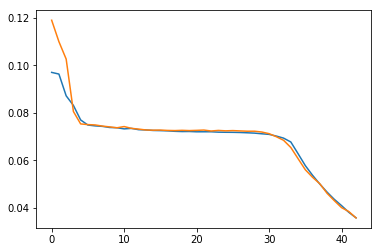

저-------------이  게-장이  모-든 도ᅩ-곡이ᅵ   ---이-먼ᄌ지ᄋ이  쳐-고ᅩᅩ  ---상지  ᅥᆨ슬 튼 다-지ᅵᅵ  바-이  판아-를라ᅡᆸ니--------------------------------------------------------다.<eos><eos>
저이 게장이 모든 도곡이 이먼지이 쳐고 상지 ᅥᆨ슬 튼 다지 바이 판아를랍니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


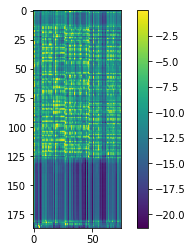

우------------릴 개-아-게ᄂ은  ----애-국이 이 엇새-글ᆯ이연 -한구-거  간장가  마ᄅ라 개헤 있ᆻ습니------------------------------------------------다.<eos><eos>
우릴 개아게ᄂ은 애국이 이 엇새글이연 한구거 간장가 마라 개헤 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


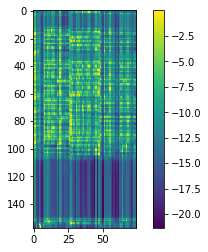

-------------------------------------------------------------------------------------------------------
09-08 16:26:08
Mean Train Loss: 0.033943662496189936
Mean Evaluation Loss: 0.03384841636156667
-------------------------------------------------------------------------------------------------------
09-08 16:26:45
Mean Train Loss: 0.03188413556602846
Mean Evaluation Loss: 0.03240316837717956
-------------------------------------------------------------------------------------------------------
09-08 16:27:23
Mean Train Loss: 0.030328440664973113
Mean Evaluation Loss: 0.031158200860338867
-------------------------------------------------------------------------------------------------------
09-08 16:28:00
Mean Train Loss: 0.02864999102115941
Mean Evaluation Loss: 0.030409797720479297
-------------------------------------------------------------------------------------------------------
09-08 16:28:39
Mean Train Loss: 0.027377865639721995
Mean Evaluation Loss: 0.029000945911337013
----

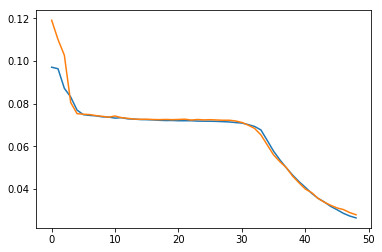

가-------------------국일 명명ᆼ가ᅡᆫ 항우 사ᅡᅡ고ᅩᆫ ᅡᅡᄋ울도ᅩ   -----그ᅳ으  ᅡᅡᄉ시가ᅡᄋ에 살ᄀ깄ᄃ다ᄀ고   마-안 먹어--------------------------------------------------------------ᆻ다.<eos><eos>
가국일 명명간 항우 사곤 ᅡ울도 그으 ᅡ시가에 살깄다고 마안 먹었다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


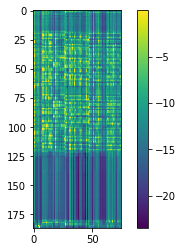

주------------------송-하-짐ᄆ만ᆫ  ---상ᄌᄌᆼᆼ이-의 겨-랙ᄋ은  --ᄉ시겸 갈은 사   ᄋᄋ는 것 ᅡᅡᆻᄉ습니------------------------------------------------다.<eos><eos>
주송하짐만 상ᄌᆼ이의 겨랙은 시겸 갈은 사 ᄋ는 것 ᅡᆻ습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


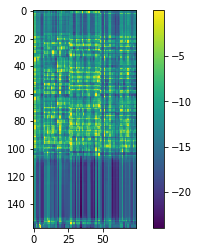

-------------------------------------------------------------------------------------------------------
09-08 16:29:55
Mean Train Loss: 0.024928986464678428
Mean Evaluation Loss: 0.026987951541273102
-------------------------------------------------------------------------------------------------------
09-08 16:30:33
Mean Train Loss: 0.02391271669038615
Mean Evaluation Loss: 0.026054229310922657
-------------------------------------------------------------------------------------------------------
09-08 16:31:10
Mean Train Loss: 0.022739286265974646
Mean Evaluation Loss: 0.025258504594250813
-------------------------------------------------------------------------------------------------------
09-08 16:31:49
Mean Train Loss: 0.021781590461948528
Mean Evaluation Loss: 0.02477907833326286
-------------------------------------------------------------------------------------------------------
09-08 16:32:26
Mean Train Loss: 0.021083991199277265
Mean Evaluation Loss: 0.024687796257293317
--

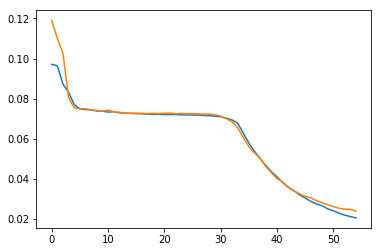

기---------------ᄌᆼᆼᄑ부이ᅵᄃ대숙ᄃ들어ᅩᅩ면-서   -----우ᄅ리는 저-장 공간이 보족드ᄃ다는 사시ᅵ을ᆯ 때 닫아-ᆻᆻᆻ-----------------------------------------------------------------어요.<eos><eos>
기ᄌᆼᄑ부이대숙들어ᅩ면서 우리는 저장 공간이 보족드다는 사시을 때 닫았어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


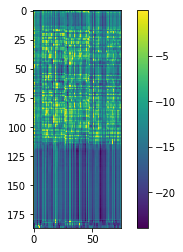

요-----------------즘에ᅦᄂ는ᆫ   ----자-기 구-모-임이 나ᅡᄉ선댕-임을   ---ᅩᅩᆼ뎡하ᅡ ᄌ ᅡᅡᆭ는ᄋᄋ해ᄃᄃᆯ이ᅵ 많ᆭ아---------------------------------------ᄋ요.<eos><eos>
요즘에는 자기 구모임이 나선댕임을 ᅩᆼ뎡하 ᄌ ᅡᆭ는ᄋ해ᄃᆯ이 많아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


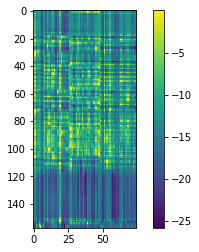

-------------------------------------------------------------------------------------------------------
09-08 16:33:42
Mean Train Loss: 0.019566590496175595
Mean Evaluation Loss: 0.022800920894494387
-------------------------------------------------------------------------------------------------------
09-08 16:34:19
Mean Train Loss: 0.01866221270434012
Mean Evaluation Loss: 0.022693056275365598
-------------------------------------------------------------------------------------------------------
09-08 16:34:58
Mean Train Loss: 0.018965139448334823
Mean Evaluation Loss: 0.022562780453800172
-------------------------------------------------------------------------------------------------------
09-08 16:35:35
Mean Train Loss: 0.01761312504612871
Mean Evaluation Loss: 0.02205036584503883
-------------------------------------------------------------------------------------------------------
09-08 16:36:13
Mean Train Loss: 0.01724125649028591
Mean Evaluation Loss: 0.021448971958816822
----

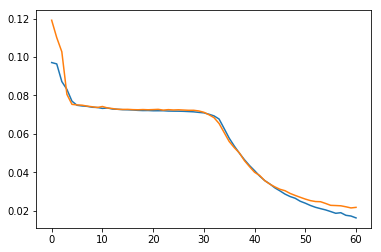

여--------------러 군은 이ᄀ곳에-서ᅥᅥ  ------장ᆼ-미ᅵ.  ------배---타,, ----필-ᄅ냇-듬 ------ᅡᅡᅡᅡᆼ한 종ᄋ일 꿋틀를 고-실 수 있습니ᅵ---------------------------------------다.<eos><eos>
여러 군은 이곳에서 장미. 배타, 필ᄅ냇듬 ᅡᆼ한 종일 꿋틀를 고실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


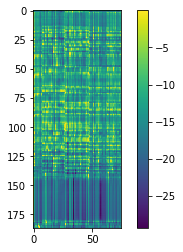

우------------리  대햐ᅣᆨ게-는  ---ᄋ애ᄀ국이 율헉 생을 면ᆫ  한구ᅮ가  관장가  말란괴ᅬ어 이ᅵᆻ습니ᅵ----------------------------------------------다.<eos><eos>
우리 대햑게는 애국이 율헉 생을 면 한구가 관장가 말란괴어 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


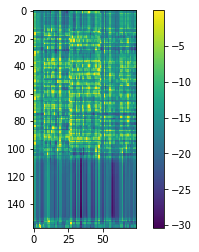

-------------------------------------------------------------------------------------------------------
09-08 16:37:28
Mean Train Loss: 0.015321038754696733
Mean Evaluation Loss: 0.021115645217269444
-------------------------------------------------------------------------------------------------------
09-08 16:38:07
Mean Train Loss: 0.014961017577000935
Mean Evaluation Loss: 0.021202293460077435
-------------------------------------------------------------------------------------------------------
09-08 16:38:44
Mean Train Loss: 0.014299053010953636
Mean Evaluation Loss: 0.020680135323844086
-------------------------------------------------------------------------------------------------------
09-08 16:39:22
Mean Train Loss: 0.013677713152380458
Mean Evaluation Loss: 0.020389719860314896
-------------------------------------------------------------------------------------------------------
09-08 16:39:59
Mean Train Loss: 0.013357903481880542
Mean Evaluation Loss: 0.021282639339852756


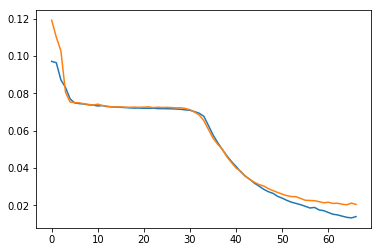

그--------------븐는 훌륭한 학자닌 거ᅥ  분명ᄒ하지ᅵᄆ만  ------저-는 뎨인-적으로   그-ᅳᅳ을 좋ᄋᄒ하지ᅵ 않ᄋ아------------------------------------------------------------ᄋᄋ요.<eos><eos>
그븐는 훌륭한 학자닌 거 분명하지만 저는 뎨인적으로 그ᅳ을 좋ᄋ하지 않아요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


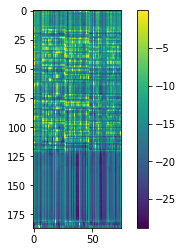

죄---------------송-하-지ᄆᄆ만ᆫ  ---선젱 니ᄋ의 계-획ᄋ은  --시-ᄋᆷᆷ ᅡᅡᄋ에 상이 없는 겉 같습니ᅵ--------------------------------------------------다..<eos>
죄송하지만 선젱 니의 계획은 시ᄋᆷ ᅡ에 상이 없는 겉 같습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


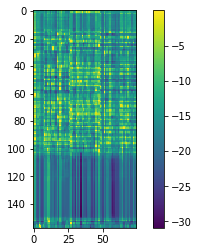

-------------------------------------------------------------------------------------------------------
09-08 16:41:16
Mean Train Loss: 0.01295682015396182
Mean Evaluation Loss: 0.019926105013393022
-------------------------------------------------------------------------------------------------------
09-08 16:41:53
Mean Train Loss: 0.012174819015458766
Mean Evaluation Loss: 0.020297553829880587
-------------------------------------------------------------------------------------------------------
09-08 16:42:31
Mean Train Loss: 0.01130038442065698
Mean Evaluation Loss: 0.019593017878209655
-------------------------------------------------------------------------------------------------------
09-08 16:43:08
Mean Train Loss: 0.010733969832148905
Mean Evaluation Loss: 0.020059256909967998
-------------------------------------------------------------------------------------------------------
09-08 16:43:46
Mean Train Loss: 0.010481093908247979
Mean Evaluation Loss: 0.019895060903576983
--

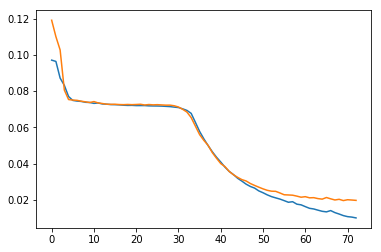

시-----------------------ᆷᆷ사ᅡ숙-복긑-태-   -----귀-어를 선바ᄒ하지 아ᅡ기로ᅩ 결정헤 슴을 알ᄅᄃᄃ들레 ᄃ되어ᅥ 이--감ᄋ입ᄂ니ᅵ---------------------------------------------------다.<eos><eos>
심사숙복긑태 귀어를 선바하지 아기로 결정헤 슴을 알ᄅ들레 되어 이감입니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


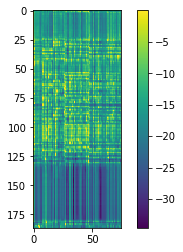

여-----------------ᆼ가  오-댄 ᅪᅪᆫ명의 ᄋᄋ-곡인 광ᆼ광-개-들이  --서ᄋ우ᄋ을 방문하고  이----------------------------------------------------------ᆻ다.<eos><eos>
영가 오댄 ᅪᆫ명의 ᄋ곡인 광광개들이 서우을 방문하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


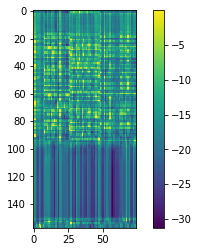

-------------------------------------------------------------------------------------------------------
09-08 16:45:03
Mean Train Loss: 0.009605166342809886
Mean Evaluation Loss: 0.01985829301302418
-------------------------------------------------------------------------------------------------------
09-08 16:45:40
Mean Train Loss: 0.009374861173937347
Mean Evaluation Loss: 0.0198937974899652
-------------------------------------------------------------------------------------------------------
09-08 16:46:17
Mean Train Loss: 0.009123780547124214
Mean Evaluation Loss: 0.02022203725566364
-------------------------------------------------------------------------------------------------------
09-08 16:46:55
Mean Train Loss: 0.008315354154716981
Mean Evaluation Loss: 0.02028292412545731
-------------------------------------------------------------------------------------------------------
09-08 16:47:33
Mean Train Loss: 0.00854979517387656
Mean Evaluation Loss: 0.020276294722359943
------

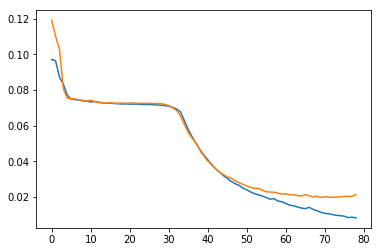

최--------------------근 보ᅩ싱이 다이 탑에 ᅥᅪ과ᄌ적일라ᅡ고 ᄋ알려ᄌ지ᄋ여ᄉ서ᅥ  --ᆨᆨᅮᆨᆨ실  ᆯᅡ는  여ᄌ자들이ᅵ   늘ᄀ고 이ᅵᆻᆻᆻ----------------------------------------------------ᄋ어요.<eos><eos>
최근 보싱이 다이 탑에 ᅥᅪ과적일라고 알려지여서 ᆨᅮᆨ실 ᆯᅡ는 여자들이 늘고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


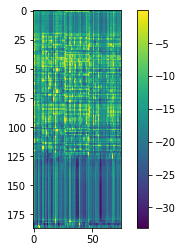

어----------리ᅵ 남-자-는   ---ᄋᄋ-리-나ᅡᄅ라에ᅦ서ᅥ   가ᄌ장 익-기-에ᄂ는  --매-곡 수-설 중ᄒ하나ᅡ-ᄋ--------------------------------------------------ᅢ요.<eos><eos>
어리 남자는 ᄋ리나라에서 가장 익기에는 매곡 수설 중하나애요.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


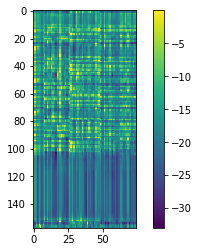

-------------------------------------------------------------------------------------------------------
09-08 16:48:49
Mean Train Loss: 0.008593378692678991
Mean Evaluation Loss: 0.020203821947678804
-------------------------------------------------------------------------------------------------------
09-08 16:49:26
Mean Train Loss: 0.007198547605602158
Mean Evaluation Loss: 0.02002778455525752
-------------------------------------------------------------------------------------------------------
09-08 16:50:04
Mean Train Loss: 0.0070436854565416075
Mean Evaluation Loss: 0.02101383868932853
-------------------------------------------------------------------------------------------------------
09-08 16:50:42
Mean Train Loss: 0.006594622953677631
Mean Evaluation Loss: 0.02043431592520887
-------------------------------------------------------------------------------------------------------
09-08 16:51:20
Mean Train Loss: 0.006363994660301648
Mean Evaluation Loss: 0.020587334781172716
--

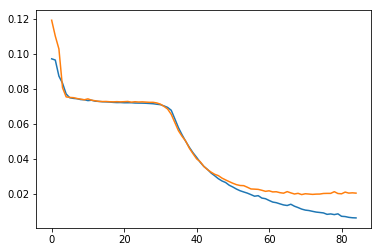

처-------------------음 이곳에 이ᅵ사 왔을 때-     -----ᄀ거-어서  다ᄂ는 거ᄅ리에 심료-품 가ᄀ게가 있다는 게ᅦᅦ   --ᄎ참  줗아---ᆻᆻᆻ-------------------------------------------어요.<eos><eos>
처음 이곳에 이사 왔을 때 거어서 다는 거리에 심료품 가게가 있다는 게 참 줗았어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


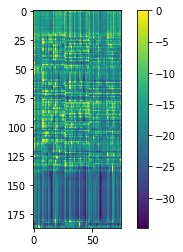

저--------------ᄂ는 그 사ᄅ람이ᅵ   ---나-이알인 여저ᅡ들ᅳᆯ 대하는 태-도-가   --마-ᅳᆷ이 안 들어----------------------------------------------------ᄋ요.<eos><eos>
저는 그 사람이 나이알인 여저ᅡ들ᅳᆯ 대하는 태도가 마ᅳᆷ이 안 들어요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


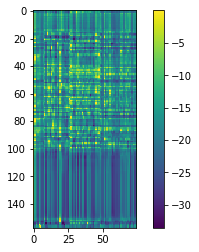

-------------------------------------------------------------------------------------------------------
09-08 16:52:36


KeyboardInterrupt: ignored

In [35]:
EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch()
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_eval.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")